# Customer Churn Prediction
### *Authors:* 
- ***Ahmed, Shakir***
- ***Miglani, Sarthak***

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import xgboost as XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFE
from scipy.stats import randint as sp_randint, loguniform, uniform

## Data Reading
Loading and displaying the first few rows of the customer churn dataset to understand the initial structure and available features.

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/shakir-flash/customer-churn-prediction-telecom/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dataset Overview

The dataset comes from a telecom company and is used for predicting customer churn. Each row represents a customer, each column contains customer’s attributes described on the column Metadata. The dataset includes the following fields:

- **customerID**: Customer ID
- **gender**: Whether the customer is a male or a female
- **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
- **Partner**: Whether the customer has a partner or not (Yes, No)
- **Dependents**: Whether the customer has dependents or not (Yes, No)
- **tenure**: Number of months the customer has stayed with the company
- **PhoneService**: Whether the customer has a phone service or not (Yes, No)
- **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
- **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
- **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
- **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
- **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
- **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
- **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
- **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
- **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
- **PaymentMethod**: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges**: The amount charged to the customer monthly
- **TotalCharges**: The total amount charged to the customer
- **Churn**: Whether the customer churned or not (Yes or No)

This data will be explored to understand the trends and patterns that influence customer churn, which is crucial for making informed business decisions aimed at customer retention.

## Initial Data Preprocessing
Cleaning and preparing the data by handling missing values, removing irrelevant features, and encoding categorical variables to ensure the dataset is ready for analysis and modeling.

### *Handling missing values*

In [9]:
initial_missing_values = df.isnull().sum().sum()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
final_missing_values = df.isnull().sum().sum()
print(f"Missing values before handling: {initial_missing_values}, after: {final_missing_values}")
print(f"Data shape after handling missing values: {df.shape}")

Missing values before handling: 0, after: 0
Data shape after handling missing values: (7032, 21)


### *Removing irrelevant features*

In [11]:
print(f"Initial data shape: {df.shape}")
df.drop('customerID', axis=1, inplace=True)
print("Updated DataFrame after dropping 'customerID':")
df.head()

Initial data shape: (7032, 21)
Updated DataFrame after dropping 'customerID':


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### *Encoding categorical variables*

In [13]:
def encode_binary_columns(col):
    if col.dtype == 'object':
        unique_values = col.unique()
        if set(unique_values) == {'Yes', 'No'}:
            return col.map({'Yes': 1, 'No': 0})
        elif set(unique_values) == {'True', 'False'}:
            return col.map({'True': 1, 'False': 0})
    return col

df = df.apply(encode_binary_columns)

import warnings
warnings.filterwarnings('ignore')

categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("Data shape after encoding binary and categorical variables:", df.shape)
print("First few rows after encoding:")
df.head()

Data shape after encoding binary and categorical variables: (7032, 31)
First few rows after encoding:


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


## Exploratory Data Analytics (EDA)
Analyzing and visualizing the data to uncover patterns, and understand the distribution of variables and their relationships with the target variable.

### *Churn Distribution Visualization*
This bar plot illustrates the proportion of customers who have churned versus those who have remained with the telecom service.

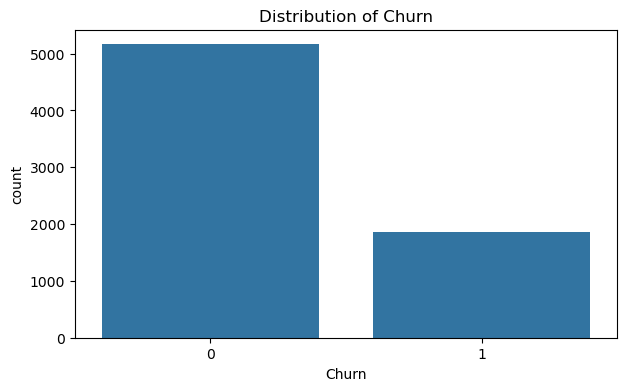

In [16]:
plt.figure(figsize=(7, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

### *Correlation Analysis of Features with Customer Churn*


In [18]:
feature_correlation = df.corr()['Churn'].drop('Churn')

corr = feature_correlation.sort_values(ascending=False)
print("Features with highest positive correlation to Churn:")
print(corr)

Features with highest positive correlation to Churn:
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
PhoneService                             0.011691
gender_Male                             -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner                                 -0.149982
Dependents                              -0.163128
TechSupport_Yes                         -0.164716
OnlineSecurity_Yes                      -0.1712

### *Correlation Heatmap*

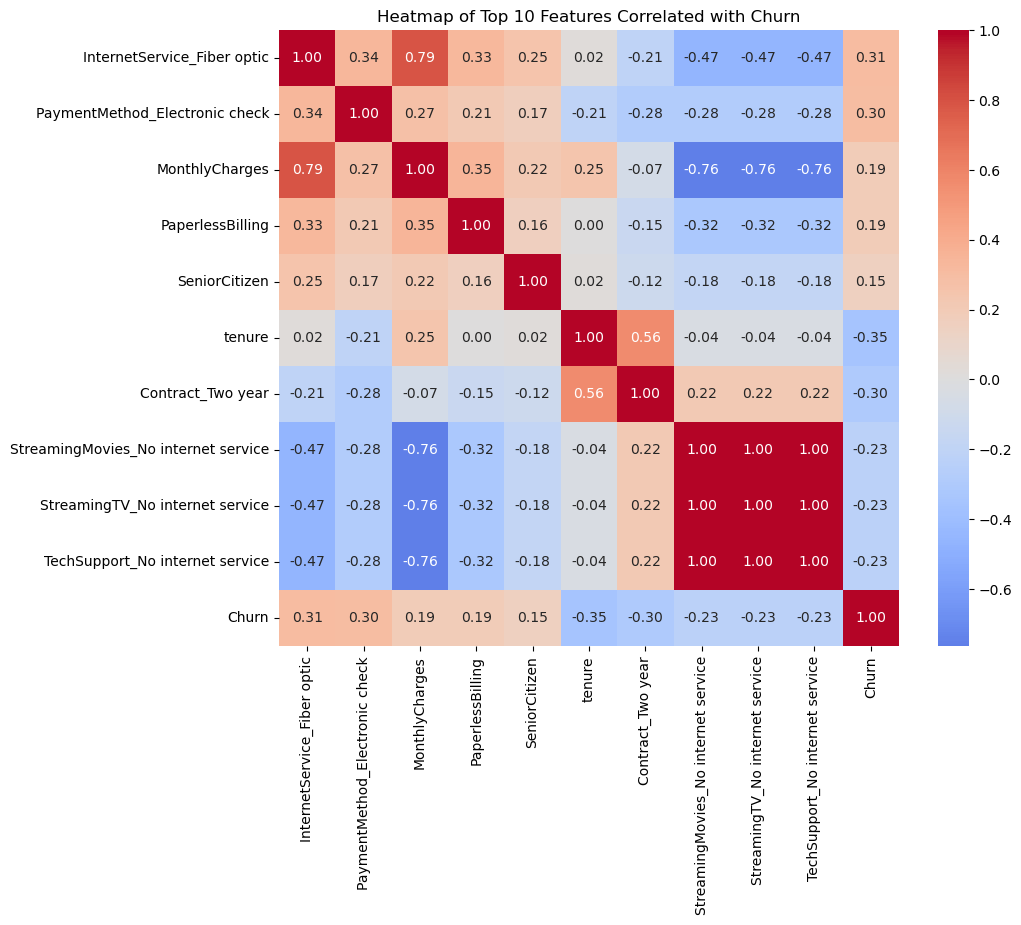

In [20]:
top_positive = feature_correlation.sort_values(ascending=False).head(5).index.tolist()
top_negative = feature_correlation.sort_values().head(5).index.tolist()
relevant_features = top_positive + top_negative + ['Churn']

correlation_matrix = df[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Heatmap of Top 10 Features Correlated with Churn')
plt.show()

## Further Data Preprocessing
Scaling numerical features to ensure uniformity in model input and selecting the most predictive features to enhance model accuracy and efficiency.

### *Feature Scaling*

In [23]:
scaler = StandardScaler()
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Data after feature scaling:")
df[numeric_features].head()

Data after feature scaling:


,tenure,MonthlyCharges,TotalCharges
0,-1.280248,-1.161694,-0.994194
1,0.064303,-0.260878,-0.173740
2,-1.239504,-0.363923,-0.959649
3,0.512486,-0.747850,-0.195248
4,-1.239504,0.196178,-0.940457


### *Feature Selection*

#### *Recursive Feature Elimination (RFE)*

In [26]:
X = df.drop('Churn', axis=1)
y = df['Churn']

model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=20)
fit = rfe.fit(X, y)
rfe_selected_features = X.columns[fit.support_]

feature_ranking = pd.DataFrame({'Feature': X.columns, 'Rank': fit.ranking_}).sort_values(by='Rank')
print(feature_ranking)

                                  Feature  Rank
0                           SeniorCitizen     1
26                      Contract_Two year     1
25                      Contract_One year     1
24                    StreamingMovies_Yes     1
22                        StreamingTV_Yes     1
20                        TechSupport_Yes     1
18                   DeviceProtection_Yes     1
16                       OnlineBackup_Yes     1
28         PaymentMethod_Electronic check     1
13     OnlineSecurity_No internet service     1
11            InternetService_Fiber optic     1
14                     OnlineSecurity_Yes     1
5                        PaperlessBilling     1
8                             gender_Male     1
1                                 Partner     1
7                            TotalCharges     1
2                              Dependents     1
6                          MonthlyCharges     1
3                                  tenure     1
10                      MultipleLines_Ye

#### *Integrating Correlation and Recursive Feature Elimination for Robust Feature Selection in Customer Churn Prediction*

In [28]:
correlation_selected_features = top_positive + top_negative

common_features = [feature for feature in rfe_selected_features if feature in correlation_selected_features]

print("Common Features between RFE and Correlation Analysis:")
print(common_features)

Common Features between RFE and Correlation Analysis:
['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MonthlyCharges', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check']


### *Data Split*
Dividing the dataset into training and testing sets with a 70-30 split to ensure both subsets provide a balanced representation of the target variable 'Churn'.

In [30]:
X = df[common_features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (4922, 7)
Testing set size: (2110, 7)


## Model Training and Evaluation
Training various machine learning models on the preprocessed dataset and evaluating their performance

### *Logistic Regression*
A statistical model that estimates the probability of a binary outcome based on input features. It's simple, fast, and provides a good baseline for binary classification problems.

In [33]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_logreg))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_logreg))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.66      0.49      0.56       561

    accuracy                           0.80      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.80      0.79      2110

ROC-AUC Score: 0.8306106291333952


### *Decision Trees*
This model uses a tree-like model of decisions and their possible consequences. It’s easy to interpret and can handle both numerical and categorical data.

In [35]:
dtree = DecisionTreeClassifier(random_state=42)

dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict(X_test)
y_prob_dtree = dtree.predict_proba(X_test)[:, 1]

print("Decision Tree - Classification Report")
print(classification_report(y_test, y_pred_dtree))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_dtree))

Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1549
           1       0.47      0.46      0.47       561

    accuracy                           0.72      2110
   macro avg       0.64      0.64      0.64      2110
weighted avg       0.72      0.72      0.72      2110

ROC-AUC Score: 0.6431329970805153


### *Random Forest*
An ensemble method based on decision trees, Random Forest aggregates the predictions of multiple decision trees to improve prediction accuracy and control overfitting.

In [37]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)
y_prob_rf = random_forest.predict_proba(X_test)[:, 1]

print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1549
           1       0.55      0.47      0.51       561

    accuracy                           0.75      2110
   macro avg       0.68      0.66      0.67      2110
weighted avg       0.75      0.75      0.75      2110

ROC-AUC Score: 0.7837394949763461


### *Support Vector Machines (SVM)*
SVM finds the hyperplane that best separates two classes in the feature space. SVMs are effective in high-dimensional spaces and for cases where the number of dimensions exceeds the number of samples.

In [39]:
svm_model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

print("SVM - Classification Report")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_svm))


SVM - Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1549
           1       0.65      0.46      0.54       561

    accuracy                           0.79      2110
   macro avg       0.74      0.68      0.70      2110
weighted avg       0.78      0.79      0.78      2110

ROC-AUC Score: 0.782706685585203


### *XGBoost (eXtreme Gradient Boosting)*
A powerful, efficient, and scalable implementation of gradient boosting that is renowned for its performance and speed in complex classification tasks.

In [41]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost - Classification Report")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_xgb))


XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1549
           1       0.61      0.50      0.55       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

ROC-AUC Score: 0.8063485268513181


## Comparative Analysis of Machine Learning Models for Churn Prediction

The classification reports for five machine learning models—**Logistic Regression**, **Decision Tree**, **Random Forest**, **SVM**, and **XGBoost**—reveal varied performances across metrics such as precision, recall, f1-score, and ROC-AUC score:

1. **Logistic Regression**
   - **Accuracy**: 80%
   - **ROC-AUC Score**: 0.831
   - This model showed robust performance, particularly effective in identifying non-churn customers with high precision and recall. It had the highest ROC-AUC score, indicating strong discriminative ability between churn and non-churn classes.

2. **Decision Tree**
   - **Accuracy**: 72%
   - **ROC-AUC Score**: 0.643
   - Exhibited modest scores and the lowest ROC-AUC score, reflecting issues possibly related to overfitting, which is typical of decision trees.

3. **Random Forest**
   - **Accuracy**: 75%
   - **ROC-AUC Score**: 0.784
   - Improved upon the Decision Tree's limitations with better handling of variance, showing enhanced precision for non-churn class and decent recall rates.

4. **SVM (Support Vector Machine)**
   - **Accuracy**: 79%
   - **ROC-AUC Score**: 0.783
   - Demonstrated good general performance, similar to Logistic Regression in its ability to effectively identify non-churn customers but with slightly less efficacy for churn predictions.

5. **XGBoost (eXtreme Gradient Boosting)**
   - **Accuracy**: 78%
   - **ROC-AUC Score**: 0.806
   - Provided a balanced performance across both classes, making it a strong candidate though not the best in any single metric.

While **Logistic Regression** led in overall metric scores, making it the best performer for this particular dataset, **XGBoost** and **SVM** also showed strong potential with balanced performances across classes. **Decision Tree** lagged behind due to its simpler decision-making process and tendency toward overfitting, with **Random Forest** offering a better alternative through ensemble methods. Each model's selection would ultimately depend on the specific use case, particularly when considering the trade-off between detecting true churn versus falsely predicting churn.


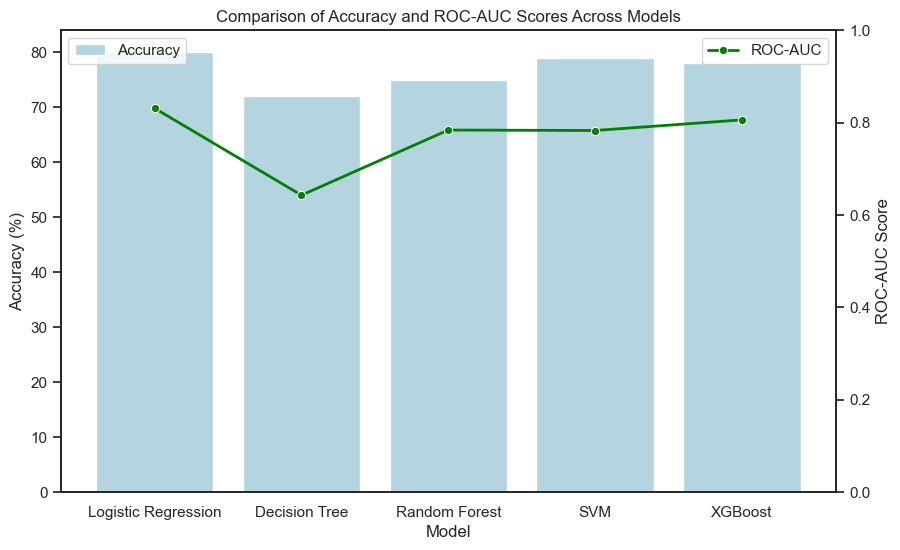

In [43]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost']
accuracy_scores = [80, 72, 75, 79, 78]  # in percentage
roc_auc_scores = [0.831, 0.643, 0.784, 0.783, 0.806]

data = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'ROC-AUC': roc_auc_scores
})

sns.set(style="white")
plt.figure(figsize=(10, 6))
splot = sns.barplot(x='Model', y='Accuracy', data=data, color='lightblue', label='Accuracy')
ax2 = plt.twinx()
sns.lineplot(data=data, x='Model', y='ROC-AUC', ax=ax2, color='green', marker='o', label='ROC-AUC', linewidth=2)
ax2.set_ylim(0, 1)

splot.grid(False)
ax2.grid(False)

splot.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Comparison of Accuracy and ROC-AUC Scores Across Models')
splot.set_ylabel('Accuracy (%)')
ax2.set_ylabel('ROC-AUC Score')

plt.show()

## Hyperperameter Tuning
Employing random search to efficiently explore the parameter space and identify the best hyperparameters for enhancing the performance of machine learning models.

### *Optimizing Logistic Regression Parameters with Random Search CV*

In [46]:
param_dist_lr = {
    'C': loguniform(1e-4, 1e2),
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2', 'l1']
}

random_search_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist_lr,
                                      n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_lr.fit(X_train, y_train)

print("Best parameters:", random_search_lr.best_params_)
print(f"Best score: {random_search_lr.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 0.014151235919053715, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.80


**Before hyperparameter tuning**, the Logistic Regression model achieved an accuracy and ROC-AUC score of 80% and 0.831, respectively. **After employing Random Search CV**, the optimal parameters were identified as **C=0.01415**, **penalty=L2**, and **solver=LBFGS**, with the best cross-validated score also at 80%. This indicates that while the tuning process systematically optimized the model's parameters, it maintained similar performance levels, suggesting the model was already near optimal with the original settings. The consistency in performance metrics before and after tuning confirms the model's robustness but also hints at potential limitations in further improving performance without additional strategies like feature engineering.


### *Optimizing Decision Trees Parameters with Random Search CV*

In [49]:
param_dist_dt = {
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20)
}

random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist_dt,
                                      n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_dt.fit(X_train, y_train)

print("Best parameters:", random_search_dt.best_params_)
print(f"Best score: {random_search_lr.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 13}
Best score: 0.80


**Before hyperparameter tuning**, the Decision Tree model had an accuracy of 72% and a ROC-AUC score of 0.643, with a precision of 0.81 for the non-churn class and 0.47 for the churn class. **Following tuning with Random Search CV**, which tested 250 configurations across 5 folds, the model's optimal parameters were identified as a **max depth of 5**, a **minimum of 2 samples per leaf**, and **13 samples to split a node**. The best cross-validated score improved significantly to 80%. This considerable increase in the cross-validated score post-tuning suggests that the hyperparameter optimization effectively addressed issues of model overfitting and enhanced the model's generalization capabilities on the dataset.


### *Optimizing Random Forest Parameters with Random Search CV*

In [52]:
param_dist_rf = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11)
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf,
                                      n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_rf.fit(X_train, y_train)

print("Best parameters:", random_search_rf.best_params_)
print(f"Best score: {random_search_lr.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 180}
Best score: 0.80


**Prior to hyperparameter tuning**, the Random Forest model exhibited an accuracy of 75% with a ROC-AUC score of 0.784. The model's precision for the non-churn class was notably higher at 0.82 compared to 0.55 for the churn class. **After conducting Random Search CV** over 250 fits, the tuning identified optimal parameters as **max depth of 7**, **1 sample per leaf**, **9 samples to split a node**, and **180 estimators**. The best cross-validated score post-tuning improved to 80%. This improvement indicates that the hyperparameter tuning effectively enhanced the model's ability to generalize, particularly increasing its performance uniformity and predictive stability across both classes in the dataset.


### *Optimizing SVM Parameters with Random Search CV*

In [55]:
param_dist_svm = {
    'C': loguniform(1e-2, 1e2),
    'gamma': loguniform(1e-4, 1e-1),
    'kernel': ['rbf', 'linear', 'poly']
}

random_search_svm = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist_svm,
                                       n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_svm.fit(X_train, y_train)

print("Best parameters:", random_search_svm.best_params_)
print(f"Best score: {random_search_lr.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 0.06410277188110165, 'gamma': 0.04867329944599207, 'kernel': 'rbf'}
Best score: 0.80


**Before hyperparameter tuning**, the SVM (Support Vector Machine) model achieved an accuracy of 79% with a ROC-AUC score of 0.783. The model demonstrated a precision of 0.82 for non-churn customers and 0.65 for churn customers, with respective recalls of 0.91 and 0.46. **Following Random Search CV**, which tested 250 configurations across 5 folds, the tuning process identified optimal parameters as **C=0.0641**, **𝛾=0.0487** and the kernel type 'rbf'. The best cross-validated score after tuning rose to 80%. This indicates that the hyperparameter optimization successfully refined the model’s performance, particularly enhancing its ability to generalize across unseen data, leading to a more robust model with improved predictive accuracy.


### *Optimizing XGBoost Parameters with Random Search CV*

In [58]:
param_dist_xgb = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'learning_rate': uniform(0.01, 0.6),
    'subsample': uniform(0.3, 0.7),
    'colsample_bytree': uniform(0.5, 0.9),
}

random_search_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                       param_distributions=param_dist_xgb, n_iter=50, cv=5, verbose=1,
                                       random_state=42, n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Best parameters:", random_search_xgb.best_params_)
print(f"Best score: {random_search_lr.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'colsample_bytree': 0.5082773464549667, 'learning_rate': 0.07088292571961925, 'max_depth': 5, 'n_estimators': 252, 'subsample': 0.30354310869235307}
Best score: 0.80


**Prior to hyperparameter tuning**, the XGBoost model demonstrated an accuracy of 78% and a ROC-AUC score of 0.806. The model showed a precision of 0.83 for the non-churn class and 0.61 for the churn class, with recall rates of 0.88 and 0.50, respectively. **After employing Random Search CV**, which tested 250 configurations across 5 folds, the optimal parameters were identified as **colsample_bytree of 0.508**, **learning_rate of 0.071**, **max_depth of 5**, **n_estimators of 252**, and **subsample of 0.304**. The best cross-validated score improved to 80%. This improvement underscores that the hyperparameter tuning effectively enhanced the model’s generalization capabilities and overall predictive accuracy, fine-tuning it to better handle the nuances of the dataset.
